In [1]:
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

# For warnings
import warnings
warnings.filterwarnings(action='ignore')

# Importing necessary packages for building and tuning our model
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from imblearn.under_sampling import NearMiss               # For Undersampling
from imblearn.over_sampling import RandomOverSampler       # For Oversampling
from imblearn.combine import SMOTETomek                    # For Both Undersampling & Oversampling
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras_tuner.tuners import RandomSearch

# For checking acuracy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
# Reading the dataset
dataset_path ='./Loan_status_2007-2020Q3.gzip'
df_read=pd.read_csv(dataset_path,low_memory=False)    # Setting low_memory=False to avoid DtypeWarning for columns with mixed data types
print("Shape of the dataset:",df_read.shape)
df_read.head()

Shape of the dataset: (2925493, 142)


,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,0,1077501,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1,1077430,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,2,1077175,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,3,1076863,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,4,1075358,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


In [3]:
df_read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2925493 entries, 0 to 2925492
Columns: 142 entries, Unnamed: 0 to debt_settlement_flag
dtypes: float64(106), int64(1), object(35)
memory usage: 3.1+ GB


In [4]:
df_read['loan_status'].value_counts()
# 目标变量

loan_status
Fully Paid                                             1497783
Current                                                1031016
Charged Off                                             362548
Late (31-120 days)                                       16154
In Grace Period                                          10028
Late (16-30 days)                                         2719
Issued                                                    2062
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                    433
Name: count, dtype: int64

In [5]:
replace_status = {"Fully Paid":"Paid",
             "Current": "Paid",
             "Charged Off": "Default",
              "Does not meet the credit policy. Status:Charged Off":"Default",
              "Does not meet the credit policy. Status:Charged Off":"Default",
              "Does not meet the credit policy. Status:Fully Paid":"Paid",
              "Late (31-120 days)":"Late",
              "Late (16-30 days)":"Late",
              "In Grace Period":"Late",
              "Default":"Default"
             }

In [6]:
df_read["loan_status"] = df_read["loan_status"].replace(replace_status)  # 根据上面的字典替换

In [7]:
df_read['loan_status'].value_counts()

loan_status
Paid       2530787
Default     363742
Late         28901
Issued        2062
Name: count, dtype: int64

<Axes: xlabel='loan_status'>

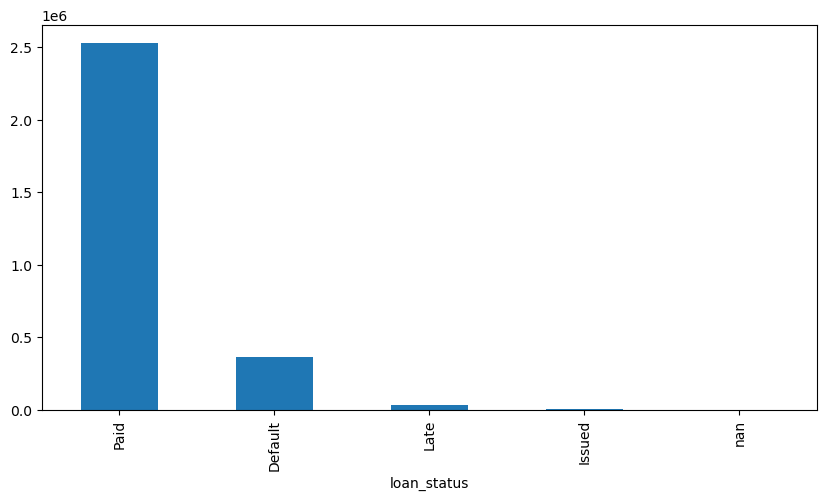

In [8]:
df_read["loan_status"].value_counts(dropna = False).plot(kind = "bar",figsize = (10,5))

In [9]:
#df = df[ (df["loan_status"]== "Paid") | (df["loan_status"]== "Default")]

In [10]:
df_read = df_read[ (df_read["loan_status"]== "Paid") | (df_read["loan_status"]== "Default")| (df_read["loan_status"]== "Late")]

In [11]:
dupe=df_read.duplicated(subset=['id','loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate'])
dupe.any()
# 去除重复

False

## 1.3 loan_status
<a id="1.3"></a>

<Axes: xlabel='loan_status', ylabel='count'>

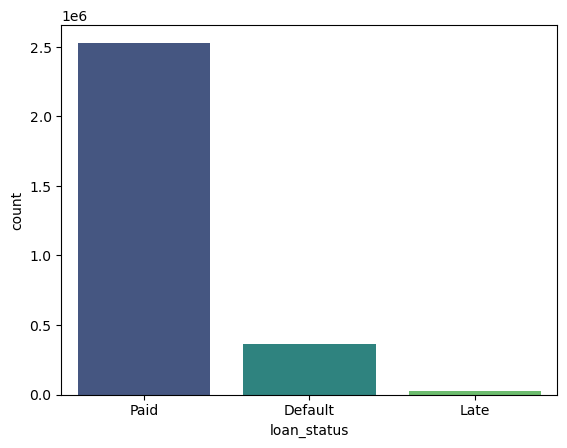

In [12]:
sns.countplot(x=df_read['loan_status'], data=df_read, palette='viridis')

In [13]:
df_read['loan_status'].value_counts()

loan_status
Paid       2530787
Default     363742
Late         28901
Name: count, dtype: int64

In [14]:
# 只保留缺失值少于20%的特征
features_to_keep = df_read.columns[((df_read.isnull().sum()/len(df_read))*100 < 20)].to_list()
print("Total features before:",len(df_read.columns))
print("Total features now:",len(features_to_keep))

Total features before: 142
Total features now: 93


In [15]:
df1=df_read[features_to_keep]  #初步筛掉空值多的列

In [16]:
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,2923430.0,87032.346689,80486.818552,0.00,32914.00,68976.0,107330.00,421094.00
loan_amnt,2923430.0,15358.353475,9478.041489,500.00,8000.00,13000.0,20000.00,40000.00
funded_amnt,2923430.0,15354.280409,9476.801625,500.00,8000.00,13000.0,20000.00,40000.00
funded_amnt_inv,2923430.0,15339.613088,9480.294433,0.00,8000.00,13000.0,20000.00,40000.00
installment,2923430.0,452.374195,272.934749,4.93,253.50,382.3,603.85,1719.83
...,...,...,...,...,...,...,...,...
tax_liens,2923325.0,0.036167,0.332568,0.00,0.00,0.0,0.00,85.00
tot_hi_cred_lim,2853154.0,183217.808595,185187.088994,0.00,52575.25,118082.0,264741.75,9999999.00
total_bal_ex_mort,2873400.0,52650.348660,51812.625338,0.00,21336.00,38835.0,66441.00,3408095.00
total_bc_limit,2873400.0,24758.465385,24360.559699,0.00,8900.00,17500.0,32500.00,1569000.00


In [17]:
#看一下空值的比例
((df1.isnull().sum()/len(df1))*100).sort_values(ascending=False)

mths_since_recent_inq    12.715304
emp_title                 9.024741
emp_length                7.014432
num_tl_120dpd_2m          5.530216
mo_sin_old_il_acct        5.324567
                           ...    
total_pymnt               0.000000
out_prncp_inv             0.000000
out_prncp                 0.000000
initial_list_status       0.000000
debt_settlement_flag      0.000000
Length: 93, dtype: float64

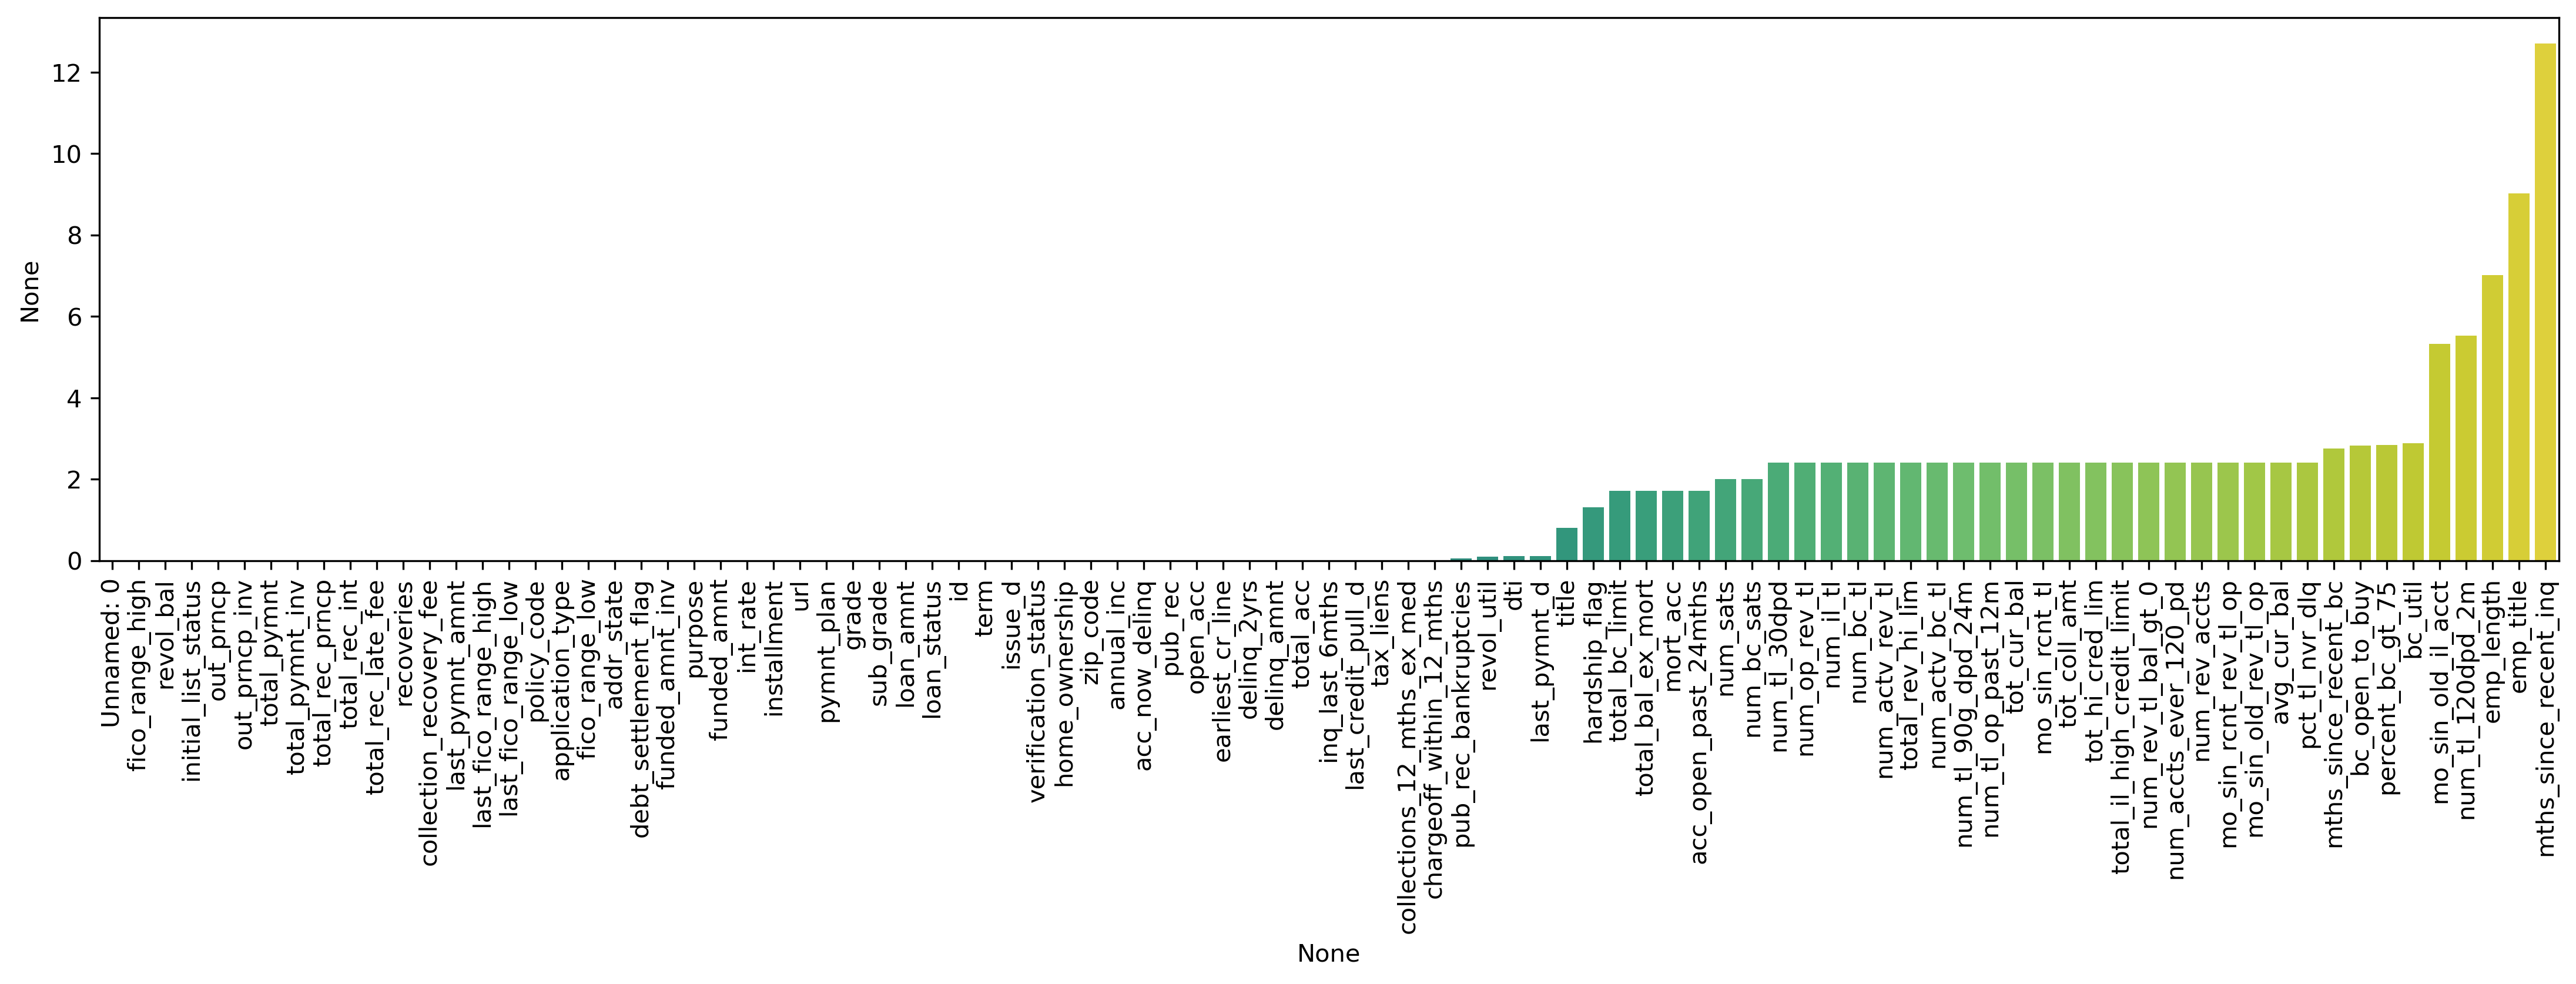

In [18]:
plt.figure(figsize=(18,4),dpi=300) # make image larger and clearer
# Y包含每列缺失值的百分比，x是上述单元格中序列的索引
sns.barplot(y=((df1.isnull().sum()/len(df1))*100).sort_values(), x=((df1.isnull().sum()/len(df1))*100).sort_values().index, palette='viridis') 
plt.xticks(rotation=90); # to rotate x-axis labels from horizontal to vertical

In [19]:
#空值处理

In [20]:
features_exsit_null = df1.columns[((df1.isnull().sum()/len(df1))>0)].to_list()
print(len(df_read.columns))
print(len(features_exsit_null))
df_exsit_null=df1[features_exsit_null]

142
56


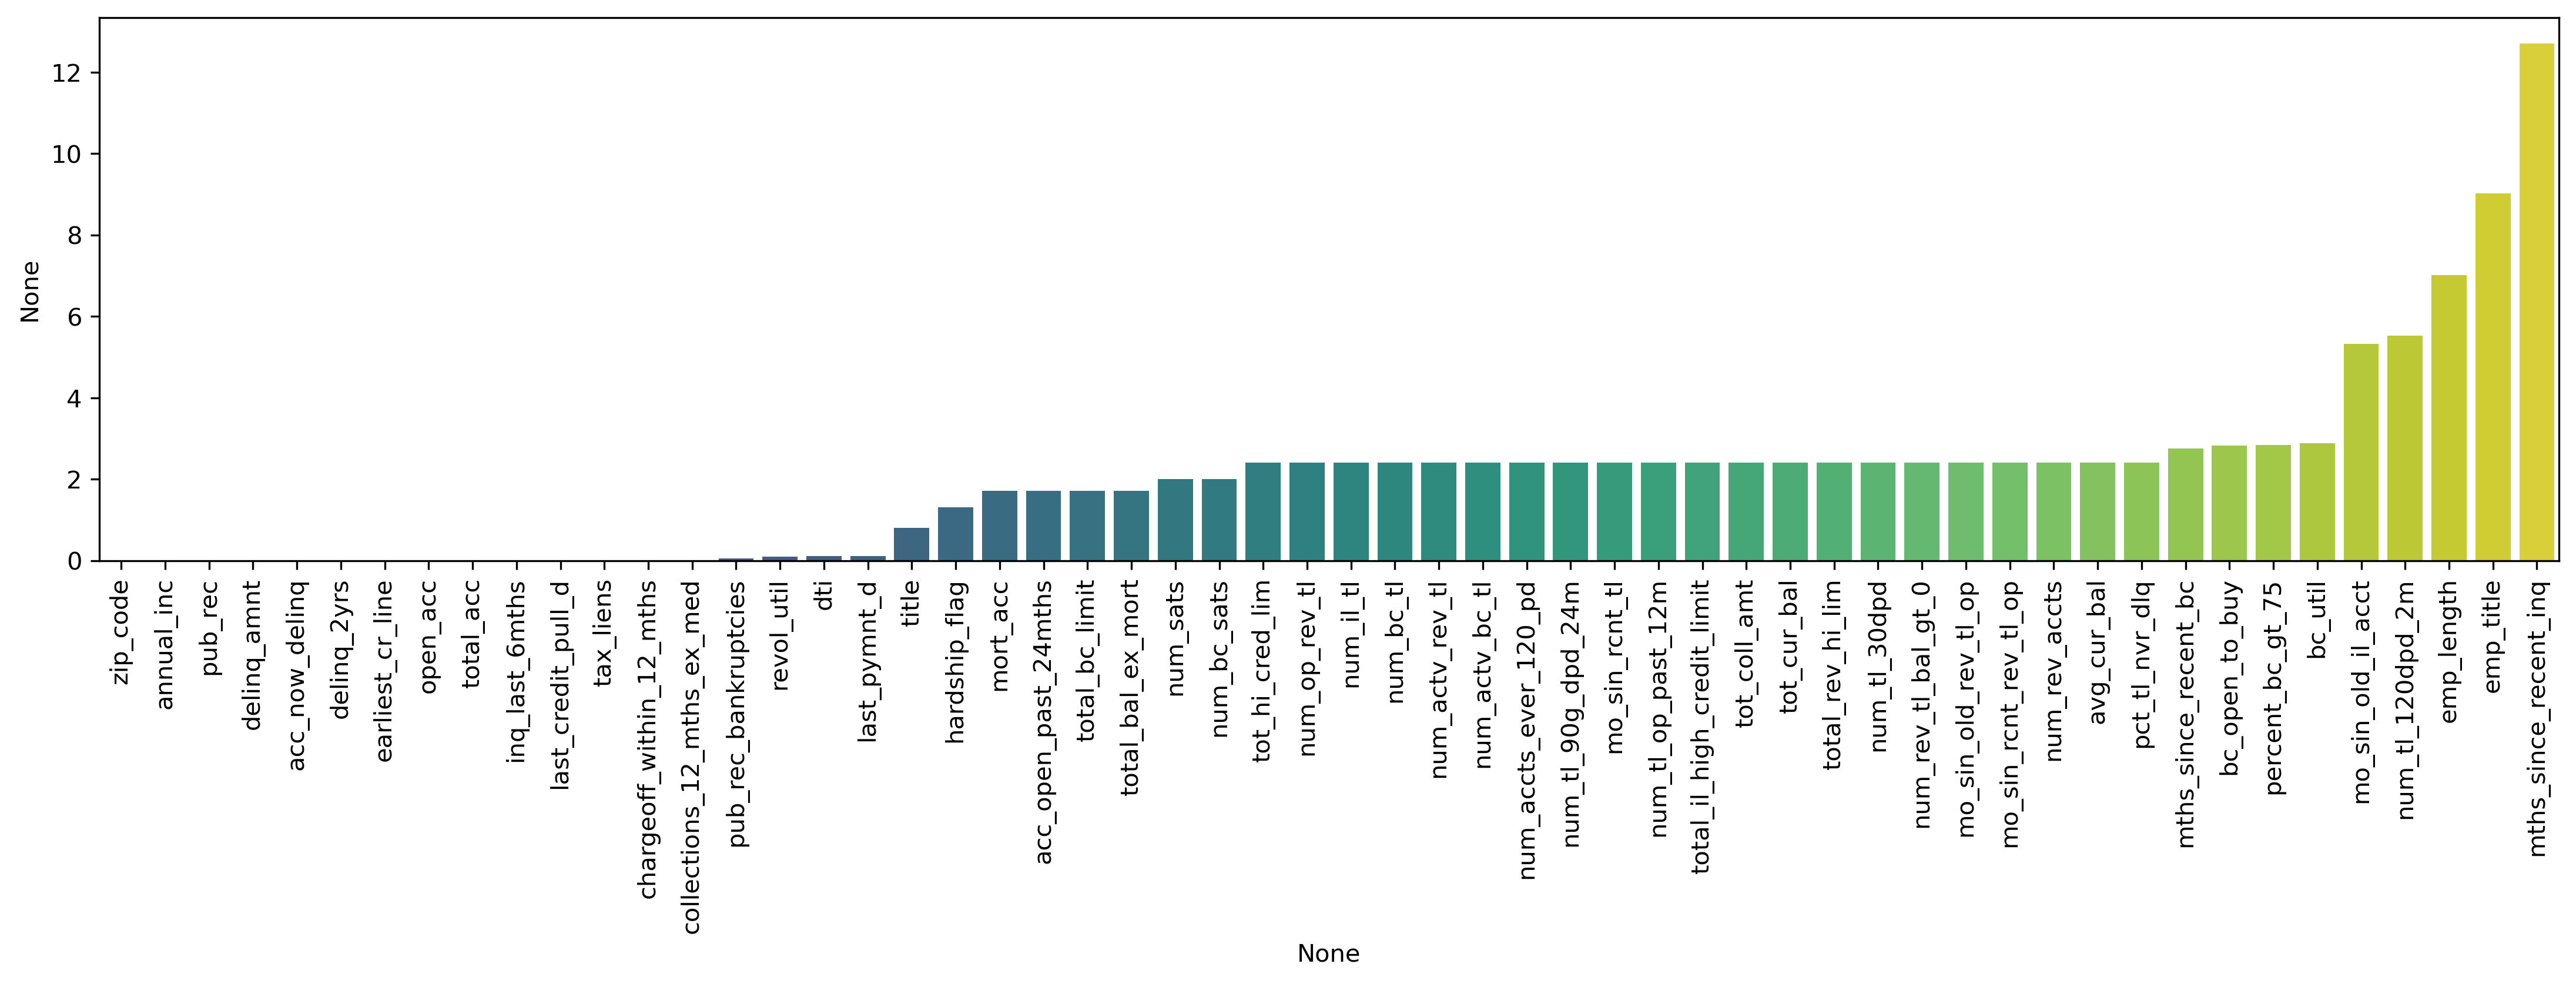

In [21]:
plt.figure(figsize=(18,4),dpi=300) # make image larger and clearer
# Y包含每列缺失值的百分比，x是上述单元格中序列的索引
sns.barplot(y=((df_exsit_null.isnull().sum()/len(df_exsit_null))*100).sort_values(), x=((df_exsit_null.isnull().sum()/len(df_exsit_null))*100).sort_values().index, palette='viridis') 
plt.xticks(rotation=90); # to rotate x-axis labels from horizontal to vertical

In [22]:

# 创建一个新的DataFrame来保存列名和数据类型
columns_info_df = pd.DataFrame({
    'Column': df1.columns,
    'Data Type': df1.dtypes
})
# 将列名和数据类型信息保存为CSV文件
columns_info_df.to_csv('features_56_type.csv', index=False)
# 打印列名和数据类型信息
print("列名和数据类型:")
print(columns_info_df)

列名和数据类型:
                                                Column Data Type
Unnamed: 0                                  Unnamed: 0     int64
id                                                  id    object
loan_amnt                                    loan_amnt   float64
funded_amnt                                funded_amnt   float64
funded_amnt_inv                        funded_amnt_inv   float64
...                                                ...       ...
total_bal_ex_mort                    total_bal_ex_mort   float64
total_bc_limit                          total_bc_limit   float64
total_il_high_credit_limit  total_il_high_credit_limit   float64
hardship_flag                            hardship_flag    object
debt_settlement_flag              debt_settlement_flag    object

[93 rows x 2 columns]


In [23]:
dupe=df1.duplicated(subset=['id','loan_amnt','funded_amnt','term','int_rate'])
dupe.any()
# 查看重复

False

没有重复

In [24]:
#根据字段含义 常识性筛选贷款发放风险有关指标，保存为features表

In [25]:
rela_features=['loan_amnt','term', 'int_rate', 'installment', 'grade', 'sub_grade','emp_length','home_ownership',
                'annual_inc','verification_status','purpose','dti','delinq_2yrs','inq_last_6mths','open_acc',
                'pub_rec','revol_bal','revol_util','total_acc','last_pymnt_amnt','loan_status','collections_12_mths_ex_med']
print(len(rela_features))

22


#### **贷款信息**
- **loan_amnt**:贷款金额
- **term**:贷款期限(36或60个月)
- **int_rate**:贷款利率
- **installment**:按月支付贷款
  #### **借款人资料**
- **grade* ::LendingClub根据借款人的资信评级
- **sub_grade*::基于借款人信誉的更详细的级 
- **emp_length*:借款人的工作年限
 - **home_ownership:*:借款人的房屋所有权类型
- **annual_inc:*:借- 年收入
- **verification_status:*:是否通过Lendi
- **collections_12_mths_ex_med**:过去12个月内除医疗外的逾期次数ng
#### **贷款详情**
-* *purpo*: *:贷款用途
- **dti:借款人的债务收入比，即每月债务支付与月收入的比率 入比
- **delinq_2yrs**:过去2年的拖欠次数
- **inq_last_6mths**:最近6个月的查询次数
- **open_ac借款人的开放信用账户数量 的数量
- **pub_rec**:贬损公共记录数
- **revol_b循环信用余额，即信用卡或类似信用产品的未结余额贷循环余额
- **revol_util**:借款人使用的信贷金额相对于其总信贷限额
- **total_借款人的总信用账户数量
Club审核

In [26]:
df_features = df1[rela_features]
df_features

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_pymnt_amnt,loan_status,collections_12_mths_ex_med
0,5000.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,24000.0,Verified,...,0.0,1.0,3.0,0.0,13648.0,83.7%,9.0,171.62,Paid,0.0
1,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,...,0.0,5.0,3.0,0.0,1687.0,9.4%,4.0,119.66,Default,0.0
2,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,...,0.0,2.0,2.0,0.0,2956.0,98.5%,10.0,649.91,Paid,0.0
3,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,...,0.0,1.0,10.0,0.0,5598.0,21%,37.0,357.48,Paid,0.0
4,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,80000.0,Source Verified,...,0.0,0.0,15.0,0.0,27783.0,53.9%,38.0,67.30,Paid,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925488,24000.0,60 months,23.99%,690.30,E,E2,< 1 year,RENT,107000.0,Source Verified,...,3.0,1.0,13.0,2.0,9688.0,24.9%,24.0,690.30,Default,1.0
2925489,10000.0,36 months,7.99%,313.32,A,A5,10+ years,MORTGAGE,65000.0,Source Verified,...,1.0,0.0,15.0,0.0,9751.0,15.7%,27.0,2151.99,Paid,0.0
2925490,10050.0,36 months,16.99%,358.26,D,D1,8 years,RENT,37000.0,Not Verified,...,0.0,1.0,15.0,0.0,14300.0,47%,21.0,358.26,Default,0.0
2925491,6000.0,36 months,11.44%,197.69,B,B4,5 years,RENT,41000.0,Source Verified,...,1.0,0.0,9.0,0.0,1356.0,10.1%,18.0,2958.01,Paid,0.0


In [28]:
# 创建一个新的DataFrame来保存列名和数据类型
columns_feature_df = pd.DataFrame({
    'Column': df_features.columns,
    'Data Type': df_features.dtypes
})
# 将列名和数据类型信息保存为CSV文件
columns_feature_df.to_csv('features_22_type.csv', index=False)
# 打印列名和数据类型信息
print("列名和数据类型:")
print(columns_feature_df)

列名和数据类型:
                                                Column Data Type
loan_amnt                                    loan_amnt   float64
term                                              term    object
int_rate                                      int_rate    object
installment                                installment   float64
grade                                            grade    object
sub_grade                                    sub_grade    object
emp_length                                  emp_length    object
home_ownership                          home_ownership    object
annual_inc                                  annual_inc   float64
verification_status                verification_status    object
purpose                                        purpose    object
dti                                                dti   float64
delinq_2yrs                                delinq_2yrs   float64
inq_last_6mths                          inq_last_6mths   float64
open_acc        

In [29]:
#至此完成22个初始参数的筛选

In [30]:
df_features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,2923430.0,15358.353475,9478.041489,500.00,8000.00,13000.00,20000.00,4.000000e+04
installment,2923430.0,452.374195,272.934749,4.93,253.50,382.30,603.85,1.719830e+03
annual_inc,2923426.0,79928.502981,111739.214286,0.00,47000.00,66000.00,95000.00,1.100000e+08
dti,2920324.0,19.295364,15.721583,-1.00,12.08,18.10,24.88,9.990000e+02
delinq_2yrs,2923401.0,0.289763,0.843805,0.00,0.00,0.00,0.00,5.800000e+01
inq_last_6mths,2923400.0,0.554268,0.860032,0.00,0.00,0.00,1.00,3.300000e+01
open_acc,2923401.0,11.675573,5.732952,0.00,8.00,11.00,15.00,1.040000e+02
pub_rec,2923401.0,0.176339,0.524495,0.00,0.00,0.00,0.00,8.600000e+01
revol_bal,2923430.0,16963.602418,22995.360761,0.00,5993.00,11492.00,20643.00,2.904836e+06
total_acc,2923401.0,24.017392,12.075599,1.00,15.00,22.00,31.00,1.760000e+02


In [31]:
df_features.isnull().sum()  # 仍然有空值

loan_amnt                          0
term                               0
int_rate                           0
installment                        0
grade                              0
sub_grade                          0
emp_length                    205062
home_ownership                     0
annual_inc                         4
verification_status                0
purpose                            0
dti                             3106
delinq_2yrs                       29
inq_last_6mths                    30
open_acc                          29
pub_rec                           29
revol_bal                          0
revol_util                      2658
total_acc                         29
last_pymnt_amnt                    0
loan_status                        0
collections_12_mths_ex_med       145
dtype: int64

In [32]:
# 计算总行数
total_count = df_features.count()
total_count

loan_amnt                     2923430
term                          2923430
int_rate                      2923430
installment                   2923430
grade                         2923430
sub_grade                     2923430
emp_length                    2718368
home_ownership                2923430
annual_inc                    2923426
verification_status           2923430
purpose                       2923430
dti                           2920324
delinq_2yrs                   2923401
inq_last_6mths                2923400
open_acc                      2923401
pub_rec                       2923401
revol_bal                     2923430
revol_util                    2920772
total_acc                     2923401
last_pymnt_amnt               2923430
loan_status                   2923430
collections_12_mths_ex_med    2923285
dtype: int64

In [33]:
couny_rows = max(total_count)
couny_rows

2923430

# 空值列的处理，同时查看列的有效性

## 1 emp_length处理

工作年限。取值范围为0 ~ 10，其中0表示少于一年，10表示超过十年。

In [34]:
# 计算'emp_length'列的空值数量
null_count = df_features['emp_length'].isnull().sum()
# 计算空值比例
null_ratio = null_count / couny_rows
null_ratio

0.07014431677857859

In [35]:
df_features['emp_length'].head()

0    10+ years
1     < 1 year
2    10+ years
3    10+ years
4       1 year
Name: emp_length, dtype: object

In [36]:
df_features['emp_length']

0          10+ years
1           < 1 year
2          10+ years
3          10+ years
4             1 year
             ...    
2925488     < 1 year
2925489    10+ years
2925490      8 years
2925491      5 years
2925492      4 years
Name: emp_length, Length: 2923430, dtype: object

创建一个升序列表

<Axes: xlabel='emp_length', ylabel='count'>

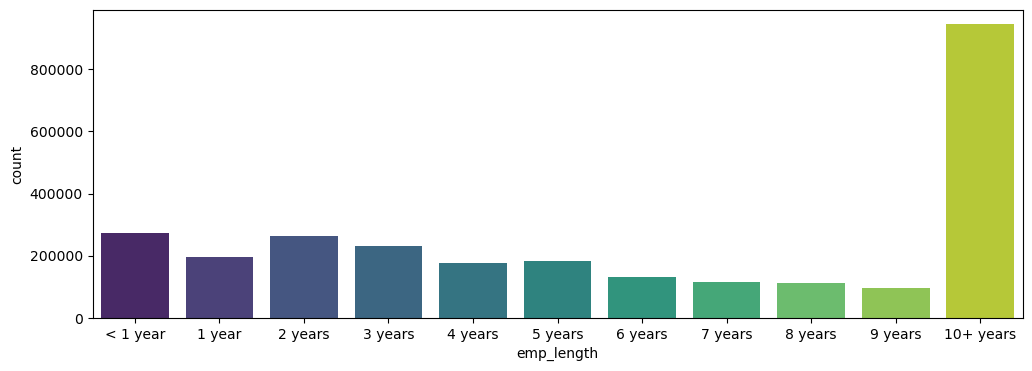

In [37]:
emp_length_order = [ '< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
plt.figure(figsize=(12,4))
sns.countplot(x='emp_length',data=df_features,order=emp_length_order, palette='viridis')

<Axes: xlabel='emp_length', ylabel='count'>

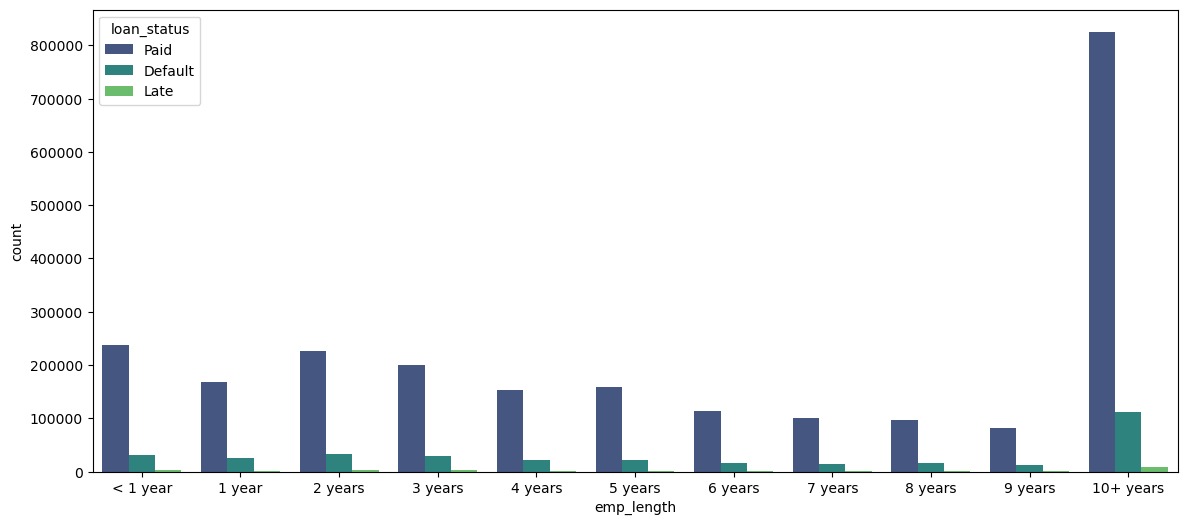

In [38]:
plt.figure(figsize=(14,6))
sns.countplot(x='emp_length',data=df_features,order=emp_length_order,hue='loan_status', palette='viridis')

这仍然没有指示emp_length和charged off.之间是否存在任何关系。让我们计算一下每年charged off.的顾客的百分比


In [39]:
emp_Default = df_features[df_features['loan_status']=="Default"].groupby("emp_length").count()['loan_status']
emp_paid = df_features[df_features['loan_status']=="Paid"].groupby("emp_length").count()['loan_status']
emp_Late = df_features[df_features['loan_status']=="Late"].groupby("emp_length").count()['loan_status']
percentage_Default = (emp_Default * 100)/(emp_Default + emp_paid + emp_Late)
percentage_paid = (emp_paid * 100)/(emp_Default + emp_paid + emp_Late)
percentage_Late = (emp_Late * 100)/(emp_Default + emp_paid + emp_Late)

In [40]:
percentage_Default,percentage_paid,percentage_Late

(emp_length
 1 year       12.787767
 10+ years    11.745553
 2 years      12.433606
 3 years      12.614475
 4 years      12.490768
 5 years      12.331060
 6 years      12.360032
 7 years      12.841735
 8 years      13.487505
 9 years      13.344100
 < 1 year     11.698908
 Name: loan_status, dtype: float64,
 emp_length
 1 year       86.243861
 10+ years    87.341523
 2 years      86.640504
 3 years      86.433538
 4 years      86.510994
 5 years      86.717442
 6 years      86.716161
 7 years      86.337498
 8 years      85.704647
 9 years      85.848374
 < 1 year     87.062293
 Name: loan_status, dtype: float64,
 emp_length
 1 year       0.968372
 10+ years    0.912924
 2 years      0.925891
 3 years      0.951987
 4 years      0.998239
 5 years      0.951498
 6 years      0.923807
 7 years      0.820767
 8 years      0.807848
 9 years      0.807526
 < 1 year     1.238799
 Name: loan_status, dtype: float64)

<Axes: xlabel='emp_length'>

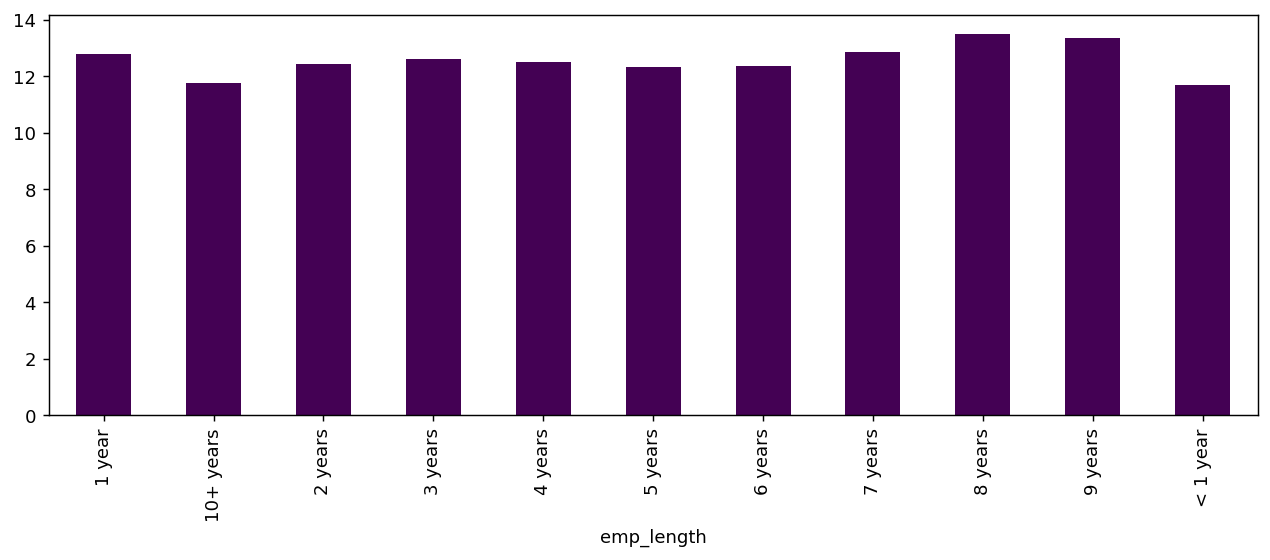

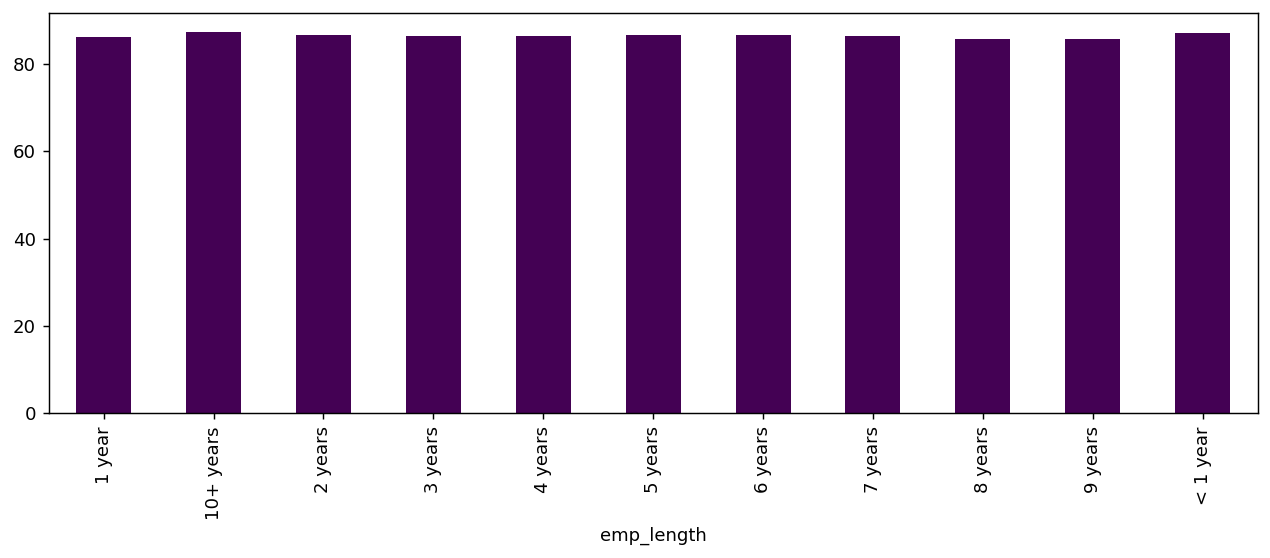

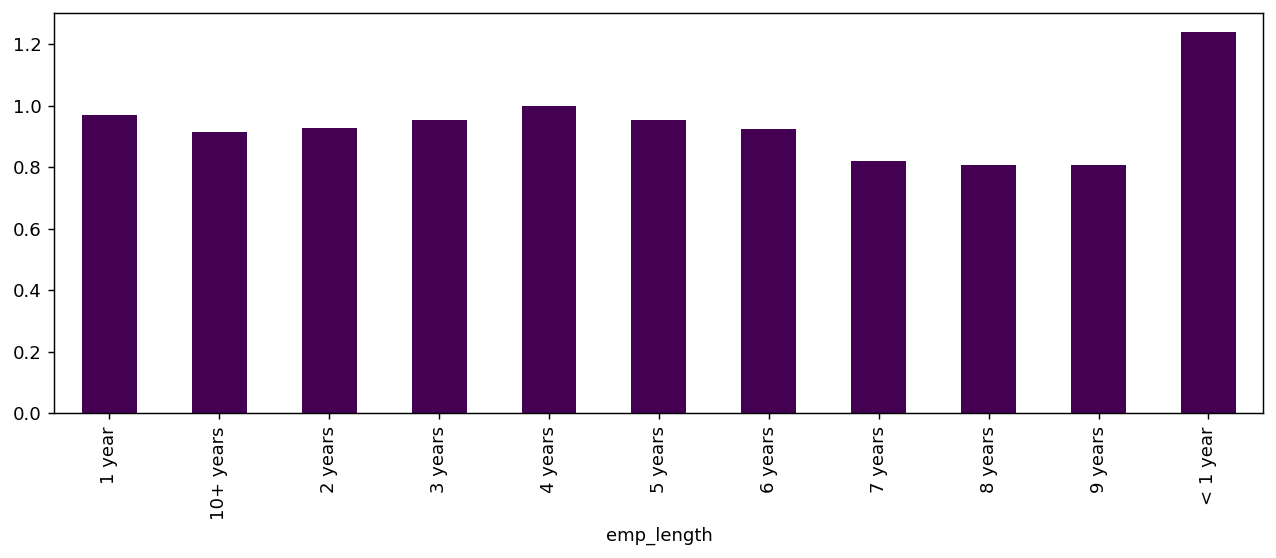

In [41]:
plt.figure(figsize=(12,4), dpi=130)
percentage_Default.plot(kind='bar', cmap='viridis')
plt.figure(figsize=(12,4), dpi=130)
percentage_paid.plot(kind='bar', cmap='viridis')
plt.figure(figsize=(12,4), dpi=130)
percentage_Late.plot(kind='bar', cmap='viridis')

其他缺的比较少的列

- delinq_2yrs                       29
- dti                             3106
- inq_last_6mths                    30
- open_acc                          29
- pub_rec                           29
- revol_util                      2658
- total_acc                         29
- collections_12_mths_ex_med       145
- annual_inc                         4

In [42]:
# 定义要检查空值比例的列名
columns_to_check = ['emp_length','delinq_2yrs', 'dti','inq_last_6mths','open_acc','pub_rec','revol_util','total_acc','collections_12_mths_ex_med','annual_inc']

# 初始化空值比例的字典
null_ratios = {}

# 遍历列名，计算每列的空值比例
for column in columns_to_check:
    null_count = df_features[column].isnull().sum()
    total_count = df_features[column].count()
    null_ratio = null_count / total_count if total_count > 0 else 0
    null_ratios[column] = null_ratio

# 打印每列的空值比例
for column, ratio in null_ratios.items():
    print(f"{column} 空值比例: {ratio:.2%}")

emp_length 空值比例: 7.54%
delinq_2yrs 空值比例: 0.00%
dti 空值比例: 0.11%
inq_last_6mths 空值比例: 0.00%
open_acc 空值比例: 0.00%
pub_rec 空值比例: 0.00%
revol_util 空值比例: 0.09%
total_acc 空值比例: 0.00%
collections_12_mths_ex_med 空值比例: 0.00%
annual_inc 空值比例: 0.00%


'emp_length'确实达到7.54%，需要处理

In [43]:
#根据空值比例发现占比非常小，可以直接删除，增加准确度
# 删除指定列中包含空值的行
df_cleaned_1 = df_features.dropna(subset=columns_to_check)
# 打印处理后的DataFrame的行数

In [44]:
total_count = df_cleaned_1.count()
total_count

loan_amnt                     2715568
term                          2715568
int_rate                      2715568
installment                   2715568
grade                         2715568
sub_grade                     2715568
emp_length                    2715568
home_ownership                2715568
annual_inc                    2715568
verification_status           2715568
purpose                       2715568
dti                           2715568
delinq_2yrs                   2715568
inq_last_6mths                2715568
open_acc                      2715568
pub_rec                       2715568
revol_bal                     2715568
revol_util                    2715568
total_acc                     2715568
last_pymnt_amnt               2715568
loan_status                   2715568
collections_12_mths_ex_med    2715568
dtype: int64

到这里空值已经填完了

In [45]:
df_cleaned_1.isnull().sum()  # 验证一下

loan_amnt                     0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
purpose                       0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
last_pymnt_amnt               0
loan_status                   0
collections_12_mths_ex_med    0
dtype: int64

没有重复行

In [46]:
df_cleaned_1

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_pymnt_amnt,loan_status,collections_12_mths_ex_med
0,5000.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,24000.0,Verified,...,0.0,1.0,3.0,0.0,13648.0,83.7%,9.0,171.62,Paid,0.0
1,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,...,0.0,5.0,3.0,0.0,1687.0,9.4%,4.0,119.66,Default,0.0
2,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,...,0.0,2.0,2.0,0.0,2956.0,98.5%,10.0,649.91,Paid,0.0
3,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,...,0.0,1.0,10.0,0.0,5598.0,21%,37.0,357.48,Paid,0.0
4,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,80000.0,Source Verified,...,0.0,0.0,15.0,0.0,27783.0,53.9%,38.0,67.30,Paid,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925488,24000.0,60 months,23.99%,690.30,E,E2,< 1 year,RENT,107000.0,Source Verified,...,3.0,1.0,13.0,2.0,9688.0,24.9%,24.0,690.30,Default,1.0
2925489,10000.0,36 months,7.99%,313.32,A,A5,10+ years,MORTGAGE,65000.0,Source Verified,...,1.0,0.0,15.0,0.0,9751.0,15.7%,27.0,2151.99,Paid,0.0
2925490,10050.0,36 months,16.99%,358.26,D,D1,8 years,RENT,37000.0,Not Verified,...,0.0,1.0,15.0,0.0,14300.0,47%,21.0,358.26,Default,0.0
2925491,6000.0,36 months,11.44%,197.69,B,B4,5 years,RENT,41000.0,Source Verified,...,1.0,0.0,9.0,0.0,1356.0,10.1%,18.0,2958.01,Paid,0.0


# 中间结果1

In [47]:
df_cleaned_1.to_csv('preprocessing-22-featues.csv', index=False)

这个数据表去除了空值，重复值，并且常识性筛选了预贷款风险有关的22个特征
- 其中loan_status为目标变量
- 其他21个列为自变量